In [270]:
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from samples.python import video
from samples.python.common import draw_str
from sklearn.cluster import k_means
%matplotlib inline


In [271]:
plotproperties = {
    'font.size': 13,
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 'xx-large',
    'xtick.labelsize': 'xx-large',
    'xtick.major.size': 7,
    'xtick.minor.size': 5,
    'ytick.labelsize': 'xx-large',
    'ytick.major.size': 7,
    'ytick.minor.size': 5,
    'legend.fontsize': 'x-large',
    'lines.markersize': 3,
    'figure.figsize': (7, 6),
    'savefig.format': 'png',
    'savefig.dpi': 300}

matplotlib.rcParams.update(plotproperties)

In [4]:
"""
1. Extract frames by running the DavisFrameAviWriter filter. The filter settings should be stored in ``path``.
2. Record the events that occur in a small spatial window to be able to later estimate the rotation period. For this, use xytype filter and DvsSliceAviWriter. The filter settings should be stored in ``path``. We do not actually write the avi file but just a txt file containing the events. We do this twice, once with a column of pixels as window, once with only a single pixel as window.
3. Extract motion flow events by running LocalPlanesFlow filter in jaer and hitting the StartLogging button. The filter settings should be stored in ``path``. The jaer script AbstractMotionFlowIMU.java has been modified to log the low-passed motion field instead of the noisier motion vectors:

//        if (motionVectorEventLogger != null && motionVectorEventLogger.isEnabled()) {
//            String s = String.format("%d %d %d %d %.3g %.3g %.3g %d", eout.timestamp, eout.x, eout.y, eout.type, eout.velocity.x, eout.velocity.y, eout.speed, eout.hasDirection ? 1 : 0);
//            motionVectorEventLogger.log(s);
//        }
        motionField.update(ts, x, y, vx, vy, v);
        final Point3D p = motionField.velocities[x >> motionField.getMotionFieldSubsamplingShift()][y >> motionField.getMotionFieldSubsamplingShift()].getValue3D();
        final double speed = Math.sqrt(p.x * p.x + p.y * p.y);
        if (motionVectorEventLogger != null && motionVectorEventLogger.isEnabled()) {
            String s = String.format("%d %d %d %d %.3g %.3g %.3g %d", eout.timestamp, eout.x, eout.y, eout.type, p.x, p.y, speed, speed != 0 ? 1 : 0);
            motionVectorEventLogger.log(s);
        }
"""

'\n1. Extract frames by running the DavisFrameAviWriter filter. The filter settings should be stored in ``path``.\n2. Record the events that occur in a small spatial window to be able to later estimate the rotation period. For this, use xytype filter and DvsSliceAviWriter. The filter settings should be stored in ``path``. We do not actually write the avi file but just a txt file containing the events. We do this twice, once with a column of pixels as window, once with only a single pixel as window.\n3. Extract motion flow events by running LocalPlanesFlow filter in jaer and hitting the StartLogging button. The filter settings should be stored in ``path``. The jaer script AbstractMotionFlowIMU.java has been modified to log the low-passed motion field instead of the noisier motion vectors:\n\n//        if (motionVectorEventLogger != null && motionVectorEventLogger.isEnabled()) {\n//            String s = String.format("%d %d %d %d %.3g %.3g %.3g %d", eout.timestamp, eout.x, eout.y, eout.

In [140]:
path = '/mnt/2646BAF446BAC3B9/Data/optical_flow'
path_eventframes = os.path.join(path, 'event_frames')
filenames_frames = sorted([p for p in os.listdir(path_eventframes)])
filename_events = 'flow_events-2019-01-16T12-32-53+0100.txt'
filename_period_times = 'rotation_period-events.txt'
filename_period_times_single = 'rotation_period_single-events.txt'
path_aps = os.path.join(path, 'aps_frames.avi')
path_eventrates = os.path.join(path, 'eventrates.txt')

In [7]:
# Define data range to consider here. 
ts_first = 375071000  # 375432726
ts_last = 391336000  # 391171819

In [221]:
# LocalPlanes_robust
flops_per_event = 1840

# LucasKanade keypoint tracker
image_size = 346 * 260
pyramid_levels = 3
num_keypoints = 10
window_size = 15 * 15
num_iterations = 10
flops_per_frame_sparse = num_keypoints * window_size * (
        76 + 10 * window_size * num_iterations * 
        np.sum([1 / 4 ** i for i in range(pyramid_levels)]))
# The first term (2) accounts for the reverse flow computation.
# The second term represents the cost of the cv2.goodFeaturesToTrack function.
# This cost is estimated by the ratio of the time-num_calls quotients of the 
# feature tracker and the flow computation (profiled below). 
flops_per_frame_sparse *= (2 + (47.572/24959) / (25.468/49886))

# Pyramidal LucasKanade dense flow 
# http://www.ieee-hpec.org/2014/CD/index_htm_files/FinalPapers/98.pdf
num_iterations = 3
flops_per_frame_dense = image_size * (76 + 10 * window_size * num_iterations * np.sum([1 / 4 ** i for i in range(pyramid_levels)]))


In [8]:
def plot_flowvectors(f, w=None, n=10):
    fig, ax = plt.subplots()
    X, Y = np.meshgrid(np.arange(-width/2, width/2, n), np.arange(-height/2, height/2, n))
    q = ax.quiver(X, Y, f[::n, ::n, 0], f[::n, ::n, 1])
    if w is not None:
        ax.quiverkey(q, 0.5, 0.98, w * 100, '{} px/s at radius 100 px'.format(w),
                     labelpos='E', coordinates='figure')
    plt.show()

    return q


In [9]:
def get_aee(flow1, flow2):
    if len(flow1) != len(flow2):
        print("Warning: Unequal sequence length detected! ({}, {})".format(
            len(flow1), len(flow2)))
    v2 = np.sqrt(np.sum(flow2 ** 2, -1))
    v2[v2 == 0] = np.infty
    return [np.mean(np.sqrt(np.sum((f1 - f2) ** 2, -1)) / v) 
            for f1, f2, v in zip(flow1, flow2, v2)]

In [10]:
def estimate_global_rotation(flow):
    rotation_mean = np.empty(len(flow))
    rotation_std = np.empty(len(flow))
    for t in range(flow.shape[0]):
        rotation = []
        for y in range(flow.shape[1]):
            yh = y - height / 2
            for x in range(flow.shape[2]):
                xh = x - width / 2
                vx = flow[t, y, x, 0]
                vy = flow[t, y, x, 1]
                if (vx or vy) and (xh or yh):
                    rotation.append((yh * vx - xh * vy) / 
                                    (xh * xh + yh * yh))
        n = len(rotation)
        rotation_mean[t] = np.mean(rotation) if n else 0
        rotation_std[t] = np.std(rotation)  # / np.sqrt(n) if n else 0
    
    return rotation_mean / (2 * np.pi), rotation_std / (2 * np.pi)

In [11]:
def cut_time(array, start, end, shift=True, return_idxs=False):
    len_array = len(array)
    idxs = np.nonzero(np.logical_and(start <= array, array < end))
    cut_array = array[idxs]
    len_cut_array = len(cut_array)
    if len_array != len_cut_array:
        print("Cut {} timestamps.".format(len_array - len_cut_array))
    if shift:
        cut_array -= start
    if return_idxs:
        return cut_array, idxs
    else:
        return cut_array

In [12]:
def get_frame_flow(filepath_frames):
    cap = cv2.VideoCapture(filepath_frames)
    framerate = cap.get(cv2.CAP_PROP_FPS)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    # out = cv2.VideoWriter(os.path.join(path, 'flow_frames.avi'), 
    #                       cv2.VideoWriter_fourcc(*'XVID'), framerate, (width, height))
    
    _, frame_previous = cap.read()
    
    frame_previous = np.flipud(frame_previous.astype('uint8'))
    
    frame_previous = cv2.cvtColor(frame_previous, cv2.COLOR_BGR2GRAY)
    
    flow_frames = []
    
    while(True):
        is_frame, frame_current = cap.read()
    
    
        if not is_frame:
            break
    
        frame_current = np.flipud(frame_current.astype('uint8'))
    
        frame_current = cv2.cvtColor(frame_current, cv2.COLOR_BGR2GRAY)
    
        flow_frame = cv2.calcOpticalFlowFarneback(frame_previous, frame_current,
                                                  None, 0.5, 3, 15, 3, 7, 1.5, 0)
    
        flow_frames.append(flow_frame)
    
        # plot_flowvectors(flow_frame, n=8)
    
        frame_previous = frame_current
    
    flow_frames = np.array(flow_frames)
    
    # Convert from px/frame to px/s
    flow_frames *= framerate
    
    flow_frames *= 2 * np.pi
       
    cap.release()
    # out.release()
    cv2.destroyAllWindows()
    
    return flow_frames, framerate, height, width


In [13]:
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                           10, 0.03))

feature_params = dict(maxCorners=10,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7)


class TrackFlow:
    def __init__(self, video_src, circle_ts):
        self.path = os.path.split(video_src)[0]
        self.track_len = 10
        self.detect_interval = 1
        self.tracks = []
        self.cam = video.create_capture(video_src)
        self.frame_idx = 0
        self.prev_gray = None
        self.circle_ts = circle_ts
        self.frequency_per_circle_ts = []
        self.std_per_circle_ts = []

    def run(self):
        framerate = self.cam.get(cv2.CAP_PROP_FPS)
        height = int(self.cam.get(cv2.CAP_PROP_FRAME_HEIGHT))
        width = int(self.cam.get(cv2.CAP_PROP_FRAME_WIDTH))
        out = cv2.VideoWriter(os.path.join(path, 'frame_flow', 'flow_frames{}.avi'.format(framerate)),
                              cv2.VideoWriter_fourcc(*'XVID'), framerate, (width, height))
        frequencies = []
        period_idx = 0

        while True:
            _ret, frame = self.cam.read()
            if frame is None:
                break
            frame = frame.astype('uint8')
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            vis = frame.copy()

            if len(self.tracks) > 0:
                img0, img1 = self.prev_gray, frame_gray
                p0 = np.float32([tr[-1] for tr in self.tracks]).reshape(-1, 1, 2)
                p1, _st, _err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None,
                                                         **lk_params)
                p0r, _st, _err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None,
                                                          **lk_params)
                d = abs(p0 - p0r).reshape(-1, 2).max(-1)
                good = d < 1
                new_tracks = []
                for tr, (x, y), good_flag in zip(self.tracks, p1.reshape(-1, 2),
                                                 good):
                    if not good_flag:
                        continue
                    x0, y0 = tr[-1]
                    r = np.sqrt((x - width / 2)**2 + (y - height / 2)**2)
                    if r > 30:
                        f = framerate * np.arcsin(np.sqrt((x - x0)**2 + (y - y0)**2) / 2 / r) / np.pi
                        frequencies.append(f)
                    tr.append((x, y))
                    if len(tr) > self.track_len:
                        del tr[0]
                    new_tracks.append(tr)
                    cv2.circle(vis, (x, y), 2, (0, 255, 0), -1)
                self.tracks = new_tracks
                cv2.polylines(vis, [np.int32(tr) for tr in self.tracks], False,
                              (0, 255, 0))
                draw_str(vis, (20, 20), 'track count: %d' % len(self.tracks))

            if self.frame_idx % self.detect_interval == 0:
                mask = np.zeros_like(frame_gray)
                mask[:] = 255
                for x, y in [np.int32(tr[-1]) for tr in self.tracks]:
                    cv2.circle(mask, (x, y), 5, 0, -1)
                p = cv2.goodFeaturesToTrack(frame_gray, mask=mask,
                                            **feature_params)
                if p is not None:
                    for x, y in np.float32(p).reshape(-1, 2):
                        self.tracks.append([(x, y)])

            if period_idx < len(self.circle_ts) and \
                    1e6 * self.frame_idx / framerate > self.circle_ts[period_idx]:
                self.frequency_per_circle_ts.append(np.mean(frequencies))
                self.std_per_circle_ts.append(np.std(frequencies))
                frequencies = []
                period_idx += 1

            self.frame_idx += 1
            self.prev_gray = frame_gray
            cv2.imshow('lk_track', vis)
            out.write(vis)

            ch = cv2.waitKey(1)
            if ch == 27:
                break

        out.release()

        # self.frequency_per_circle_ts.append(np.mean(frequencies))
        # self.std_per_circle_ts.append(np.std(frequencies))
        
        cv2.destroyAllWindows()
        
        return np.array(self.frequency_per_circle_ts), np.array(self.std_per_circle_ts)

In [14]:
def get_flow_field(flow, ts):
    # Create a flowfield for the frames by averaging frames over one rotation period.
    flowfield_frames = []
    frame_times = np.linspace(ts[0], ts[-1], len(flow))
    t_start = 0
    for t_end in circle_ts:
        indices = np.nonzero(np.logical_and(t_start <= frame_times, frame_times < t_end))
        flowfield_frame = np.mean(flow[indices], 0)
        flowfield_frames.append(flowfield_frame)
        t_start = t_end
    
    return np.array(flowfield_frames)

In [15]:
# Columns: system_time(ms) timestamp(us) x y type vx(pps) vy(pps) speed(pps) validity
events = np.loadtxt(os.path.join(path, filename_events))

In [16]:
validity = events[:, 8].astype(bool)
ts = events[:, 1][validity]
x_addr = events[:, 2][validity].astype(int)
y_addr = events[:, 3][validity].astype(int)
flow_events = events[:, 5:7][validity]


In [17]:
ts, idxs = cut_time(ts, ts_first, ts_last, True, True)
x_addr = x_addr[idxs]
y_addr = y_addr[idxs]
flow_events = flow_events[idxs]

Cut 2 timestamps.


In [18]:
circle_ts_all = np.loadtxt(os.path.join(path, filename_period_times),
                           delimiter=',', usecols=0, unpack=True)
circle_ts_all = cut_time(circle_ts_all, ts_first, ts_last)

In [19]:
circle_ts_single = np.loadtxt(os.path.join(path, filename_period_times_single),
                              delimiter=',', usecols=0, unpack=True)
circle_ts_single = cut_time(circle_ts_single, ts_first, ts_last)
num_rotations = len(np.unique(circle_ts_single))
print(num_rotations)
print(len(circle_ts_single)) 

153
153


In [20]:
circle_ts, labels, mse = k_means(np.expand_dims(circle_ts_all, 1), num_rotations,
                                 np.expand_dims(circle_ts_single, 1), n_init=1)
circle_ts = circle_ts[:, 0]

In [21]:
rotation_gt = 1 / np.diff(circle_ts) * 1e6  # From us to s

In [22]:
std_gt = []
unique_labels, idxs = np.unique(labels, return_index=True)
for i, l in enumerate(unique_labels):
    end_idx = idxs[i+1] if i + 1 < len(unique_labels) else -1
    std_gt.append(np.sqrt(np.mean((circle_ts_all[idxs[i]: end_idx] - 
                                   circle_ts[l]) ** 2)))
std_gt = 1e6 * np.array(std_gt) / circle_ts ** 2

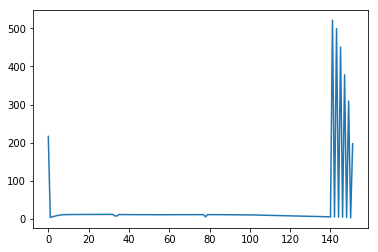

In [23]:
plt.plot(rotation_gt)

In [24]:
idxs = np.nonzero(rotation_gt < 100)
rotation_gt = rotation_gt[idxs]
std_gt = std_gt[idxs]
circle_ts = circle_ts[idxs]

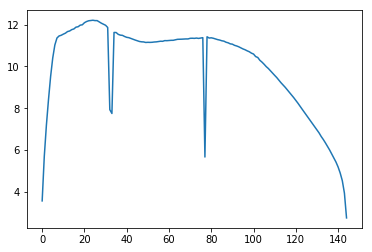

In [25]:
plt.plot(rotation_gt)

In [26]:
a = np.nonzero(rotation_gt < 10)[0]
inv_idxs = a[np.logical_and(30 < a, a < 90)]
idxs = [idx for idx in range(len(rotation_gt)) if idx not in inv_idxs]
rotation_gt = rotation_gt[idxs]
std_gt = std_gt[idxs]
circle_ts = circle_ts[idxs]

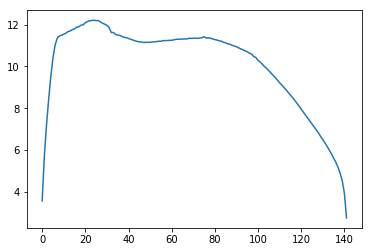

In [27]:
plt.plot(rotation_gt)

In [29]:
do_sweep = False

path_frame_flow_sweep = os.path.join(path, 'frame_flow_sweep.npz')
if do_sweep:
    frame_flow_sweep = {}
    for filename_frames in filenames_frames:
        frame_flow, frame_rate, height, width = get_frame_flow(os.path.join(path_eventframes, filename_frames))
        frame_flow_sweep[str(int(frame_rate))] = get_flow_field(frame_flow, ts)
    np.savez_compressed(path_frame_flow_sweep, **frame_flow_sweep)
else:
    width = 346
    height = 260
    frame_flow_sweep = np.load(path_frame_flow_sweep)


/home/rbodo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rbodo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [130]:
frame_flow_aps = get_flow_field(get_frame_flow(path_aps)[0], ts)

In [39]:
flow_eventframes = []
t_start = 0
for t_end in circle_ts:
    indices = np.nonzero(np.logical_and(t_start <= ts, ts < t_end))
    flow_eventframe = np.zeros((height, width, 2))
    flow_eventframe[y_addr[indices], x_addr[indices]] = flow_events[indices]
    flow_eventframes.append(flow_eventframe)
    t_start = t_end

flow_eventframes = np.array(flow_eventframes)

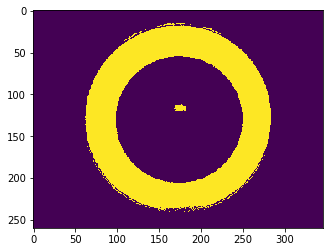

In [40]:
event_idxs = np.sum(flow_eventframes, (0, -1), keepdims=True).nonzero()
event_mask = np.zeros((1, height, width, 1))
event_mask[event_idxs] = 1
plt.imshow(event_mask[0, :, :, 0])

In [41]:
flow_gt = np.zeros((height, width, 2))
for y in range(height):
    for x in range(width):
        flow_gt[y, x, 0] = y - height / 2
        flow_gt[y, x, 1] = - x + width / 2
flow_gt = np.array([flow_gt * rot_gt for rot_gt in rotation_gt])
flow_gt *= event_mask
flow_gt *= 2 * np.pi

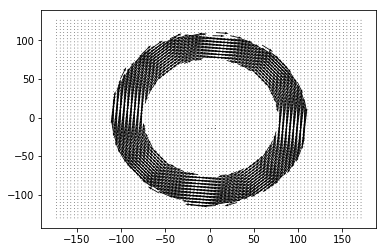

In [42]:
plot_flowvectors(flow_gt[60], 2* np.pi * rotation_gt[60], n=4)

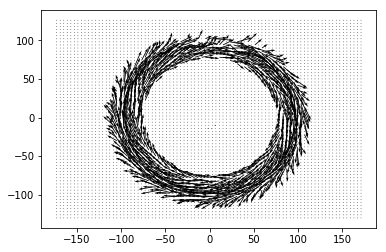

In [43]:
plot_flowvectors(flow_eventframes[60], n=4)

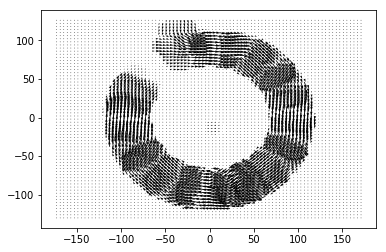

In [45]:
plot_flowvectors(frame_flow_sweep['200'][60], n=4)

In [76]:
# gt_ts_map = {k: v for k, v in enumerate(circle_ts)}
# closest_gt_idxs = [np.argmin(np.abs(np.array(list(gt_ts_map.values())) - ft)) 
#                    for ft in frame_times]
# closest_gt_frame_times = [gt_ts_map[idx] for idx in closest_gt_idxs]

In [47]:
aee_frames = {frequency: get_aee(frame_flow, flow_gt) 
              for frequency, frame_flow in frame_flow_sweep.items()}

In [131]:
aee_aps = get_aee(frame_flow_aps, flow_gt)

In [46]:
aee_eventframes = get_aee(flow_eventframes, flow_gt)

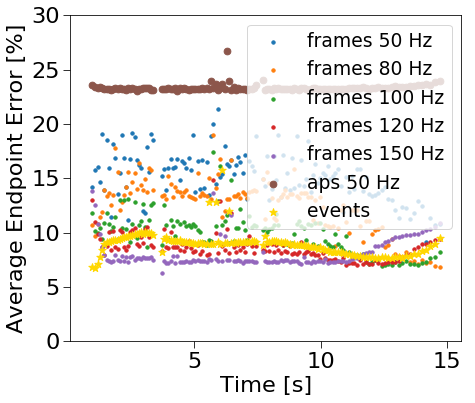

In [285]:
start_idx = 3
end_idx = -4
frequencies_to_show = ['50', '80', '100', '120', '150']
for frequency, aee in aee_frames.items():
    if frequency not in frequencies_to_show:
        continue
    plt.scatter(1e-6 * circle_ts[start_idx:end_idx], np.array(aee[start_idx:end_idx]) * 100, 45, marker='.', label='frames {} Hz'.format(frequency))
plt.scatter(1e-6 * circle_ts[start_idx:end_idx], np.array(aee_aps[start_idx:end_idx]) * 100, 45, label='aps 50 Hz')
plt.scatter(1e-6 * circle_ts[start_idx:end_idx], np.array(aee_eventframes[start_idx:end_idx]) * 100, 60, marker='*', label='events', color='gold')
plt.legend()
plt.ylim(0, 30)
plt.xlabel('Time [s]')
plt.ylabel('Average Endpoint Error [%]')
plt.savefig(os.path.join(path, 'aee_dense.png'))

In [188]:
eventrates = np.loadtxt(path_eventrates, usecols=2)
# Bring eventrates to same length as circle times.
eventrates = eventrates[sorted(np.random.choice(np.arange(len(eventrates)), len(rotation_gt)))]

In [231]:
flops_per_circle = flops_per_event * eventrates / rotation_gt 
flops_per_s_events = np.median(flops_per_event * eventrates)

220.80M flops/s


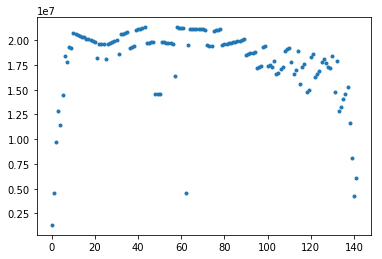

In [233]:
plt.plot(flops_per_circle, '.')
print('{:.2f}M flops/s'.format(flops_per_s_events  * 1e-6))

In [93]:
rotation_events, std_events = estimate_global_rotation(flow_eventframes)

In [92]:
if do_sweep:
    rotation_frames_sweep_dense = {frequency: estimate_global_rotation(frame_flow * event_mask)
                                   for frequency, frame_flow in frame_flow_sweep.items()}
    np.savez_compressed(os.path.join(path, 'rotation_frames_sweep_dense'), 
                        **rotation_frames_sweep_dense)
else:
    rotation_frames_sweep_dense = np.load(os.path.join(path, 'rotation_frames_sweep_dense'))

In [133]:
rotation_aps_dense, std_aps_dense = estimate_global_rotation(frame_flow_aps * event_mask)

In [213]:
if do_sweep:
    %%prun -s cumulative -T profile 
    rotation_frames_sweep_sparse = {str(int(filename_frames[-9:-6])): TrackFlow(
        os.path.join(path_eventframes, filename_frames), circle_ts).run()
                                                                    for filename_frames in filenames_frames}
    np.savez_compressed(os.path.join(path, 'rotation_frames_sweep_sparse'),
                        **rotation_frames_sweep_sparse)
else:
    rotation_frames_sweep_sparse = np.load(os.path.join(path, 'rotation_frames_sweep_sparse'))

 
*** Profile printout saved to text file 'profile'. 


In [212]:
rotation_aps_sparse, std_aps_sparse = TrackFlow(path_aps, circle_ts).run()

 
*** Profile printout saved to text file 'profile'. 


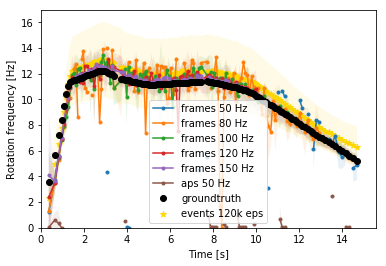

In [193]:
start_idx = 0
for frequency, (rotation_frames, std_frames) in rotation_frames_sweep_sparse.items():
    if frequency not in frequencies_to_show:
        continue
    plt.plot(1e-6 * circle_ts[start_idx:end_idx], rotation_frames[start_idx:end_idx], 
                marker='.', label='frames {} Hz'.format(frequency))
    plt.fill_between(1e-6 * circle_ts[start_idx:end_idx],
                     rotation_frames[start_idx:end_idx] - std_frames[start_idx:end_idx],
                     rotation_frames[start_idx:end_idx] + std_frames[start_idx:end_idx],
                     alpha=0.1, linewidth=0)
plt.plot(1e-6 * circle_ts[start_idx:end_idx], rotation_aps_sparse[start_idx:end_idx], 
            marker='.', label='aps 50 Hz')
plt.fill_between(1e-6 * circle_ts[start_idx:end_idx],
                 rotation_aps_sparse[start_idx:end_idx] - std_aps_sparse[start_idx:end_idx],
                 rotation_aps_sparse[start_idx:end_idx] + std_aps_sparse[start_idx:end_idx],
                 alpha=0.1, linewidth=0)
plt.scatter(1e-6 * circle_ts[start_idx:end_idx], rotation_events[start_idx:end_idx], 
            color='gold', marker='*', label='events 120k eps')
plt.fill_between(1e-6 * circle_ts[start_idx:end_idx],
                 rotation_events[start_idx:end_idx] - std_events[start_idx:end_idx],
                 rotation_events[start_idx:end_idx] + std_events[start_idx:end_idx],
                 facecolor='gold', alpha=0.1, linewidth=0)
plt.plot(1e-6 * circle_ts[start_idx:end_idx], rotation_gt[start_idx:end_idx], 'ko', label='groundtruth')
plt.fill_between(1e-6 * circle_ts[start_idx:end_idx],
                 rotation_gt[start_idx:end_idx] - std_gt[start_idx:end_idx],
                 rotation_gt[start_idx:end_idx] + std_gt[start_idx:end_idx],
                 facecolor='k', alpha=0.1, linewidth=0)
plt.ylim(0, None)
plt.xlim(0, None)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Rotation frequency [Hz]')
plt.savefig(os.path.join(path, 'tradeoff_sparse.png'))


In [331]:
def plot_tradeoff(flops_per_frame, rotation_aps, std_aps, rotation_frames_sweep, filename):
    matplotlib.rcParams['grid.alpha'] = 0.5
    
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection='3d')
    markersize = 150
    costs = 1e-9 * np.array(list(np.array(frequencies_to_show, int) * 
                                 flops_per_frame) + 
                            [50 * flops_per_frame, flops_per_s_events])
    max_cost = np.max(costs)
    colors = plt.cm.get_cmap('coolwarm')(costs / max_cost)
    start_idx = 0
    idxs = slice(start_idx, end_idx)
    times = 1e-6 * circle_ts[idxs]
    cost_points = np.ones_like(times)
    
    ax.scatter(times, 0 * cost_points, rotation_gt[idxs],
               color='k', marker='d', s=markersize, label='ground-truth')
    for j in range(len(times)):
        ax.plot([times[j], times[j]], [0, 0],
                [rotation_gt[idxs][j] - std_gt[idxs][j],
                 rotation_gt[idxs][j] + std_gt[idxs][j]],
                marker='_', color='k', alpha=0.2)
    
    ax.scatter(times, costs[-1] * cost_points, rotation_events[idxs],
               color=colors[-1], marker='*', s=markersize, label='events 120k eps')
    for j in range(len(times)):
        ax.plot([times[j], times[j]], 
                [costs[-1] * cost_points[j], costs[-1] * cost_points[j]],
                [rotation_events[idxs][j] - std_events[idxs][j],
                 rotation_events[idxs][j] + std_events[idxs][j]],
                marker='_', color=colors[-1], alpha=0.2)
    
    ax.scatter(times, costs[-2] * cost_points, rotation_aps[idxs],
               marker='X', s=markersize, label='aps 50 Hz', color=colors[-2])
    for j in range(len(times)):
        ax.plot([times[j], times[j]], 
                [costs[-2] * cost_points[j], costs[-2] * cost_points[j]],
                [rotation_aps[idxs][j] - std_aps[idxs][j],
                 rotation_aps[idxs][j] + std_aps[idxs][j]],
                marker='_', color=colors[-2], alpha=0.2)
    
    for i, frequency in enumerate(frequencies_to_show):
        rotation_frames, std_frames = rotation_frames_sweep[frequency]
        cost = costs[i]
        ax.scatter(times, cost * cost_points, rotation_frames[idxs],
                   marker='.', label='frames {} Hz'.format(frequency), 
                   color=colors[i], s=markersize)
        for j in range(len(times)):
            ax.plot([times[j], times[j]], 
                    [cost * cost_points[j], cost * cost_points[j]], 
                    [rotation_frames[idxs][j] - std_frames[idxs][j], 
                     rotation_frames[idxs][j] + std_frames[idxs][j]], 
                    marker='_', color=colors[i], alpha=0.2)
    
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_zlim(0, None)
    ax.legend(loc='best', bbox_to_anchor=(0.1, 0.5))
    ax.set_xlabel('Time [s]', labelpad=20)
    ax.set_ylabel('Comp. cost [G flops / s]', labelpad=20)
    ax.set_zlabel('Rot. frequ. [Hz]', labelpad=20)
    fig.savefig(os.path.join(path, filename))

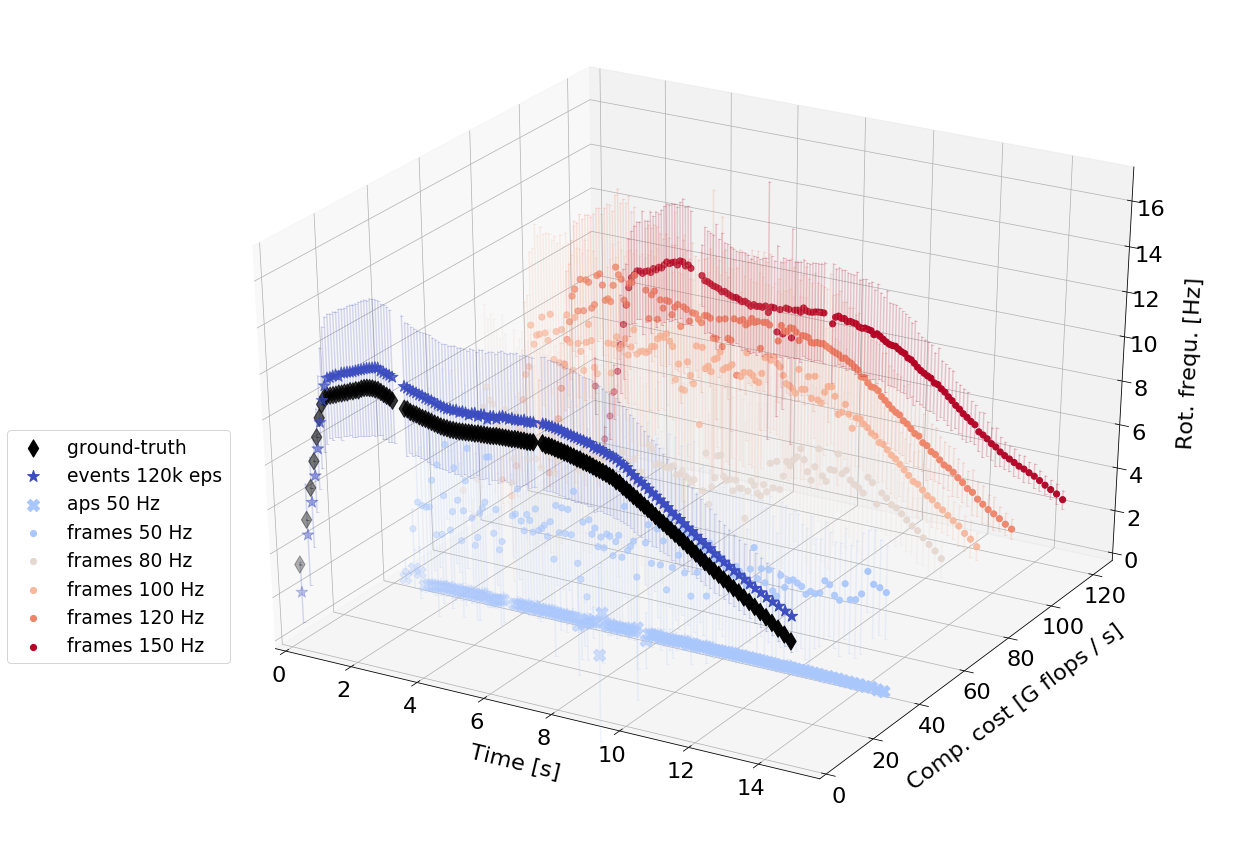

In [332]:
plot_tradeoff(flops_per_frame_dense, rotation_aps_dense, std_aps_dense, rotation_frames_sweep_dense, 'tradeoff_dense')

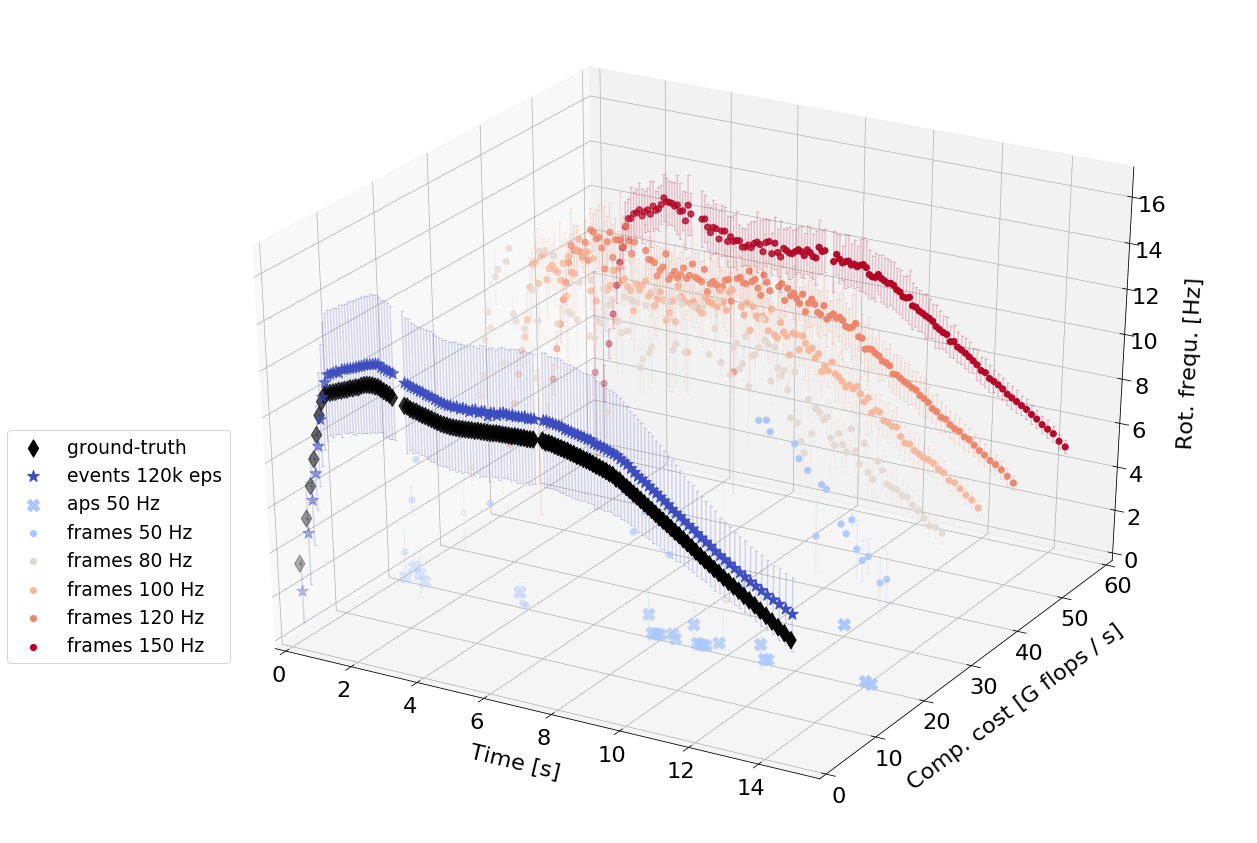

In [333]:
plot_tradeoff(flops_per_frame_sparse, rotation_aps_sparse, std_aps_sparse, rotation_frames_sweep_sparse, 'tradeoff_sparse')